# Coiled Failcase for using xhistogram on cmip6 data (simplified version based on 2021/5/3 meeting)

In [125]:
from dask_gateway import GatewayCluster
cluster = GatewayCluster()
cluster.scale(20)
cluster

In [126]:
client = cluster.get_client()
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.f032bf296137454ca35377d93205b903 Dashboard: /services/dask-gateway/clusters/prod.f032bf296137454ca35377d93205b903/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [127]:
from xhistogram.xarray import histogram
import xarray as xr
import numpy as np
import dask.array as dsa
from dask.distributed import performance_report

## Main Tweaking parameters

In [129]:
n_bins=1000 # the number of bins (for each variable). Determines the output chunk size
ct = 1 #chunking along the time dimension (which is preserved in the computation). This determines the size of the input chunks
# do we need to chunk smaller?
# cz=20


In [130]:
def pdf_wrapper(ds, bins_dict={'thetao':np.linspace(-1, 1, n_bins), 'so':np.linspace(-1, 1, n_bins)}, dim=['x', 'y', 'lev']):
    
    variables = list(bins_dict.keys())
    
    missing_vars = [var for var in variables if var not in ds.data_vars]
    if len(missing_vars) > 0:
        raise ValueError(f'Bins defined for {missing_vars} in `bins_dict` could not be found in dataset variables {list(ds.data_vars)}')
    
        
    ds = ds.squeeze()
    args = tuple([ds[v] for v in variables])
    bins = [bins_dict[v] for v in variables]
    bin_names = [v+'_bin' for v in variables]
    
    vol = ds.areacello * ds.thkcello

    hist = histogram(*args, bins=bins, weights=vol, dim=dim)
    hist = histogram(*args, bins=bins, dim=dim)
    pdf = hist
    return pdf

In [131]:
# lets create an artificial dataset for testing (this is on the lower end of resolutions for the CMIP6 data)

# nx,ny,nz,nt = 360, 291, 45, 1980
nx,ny,nz,nt = 10, 10, 10, 10
# first try it with consistent chunk sizes (the actual datases can have slightly different time chunks)
cx,cy, cz = nx, ny, nz

with dask.annotate(priority=-10):
    so = xr.DataArray(dsa.random.random([nx,ny,nz,nt], chunks=[cx,cy,cz,ct]), dims=['x', 'y', 'lev', 'time'])
    thetao = xr.DataArray(dsa.random.random([nx,ny,nz,nt], chunks=[cx,cy,cz,ct]), dims=['x', 'y', 'lev', 'time'])
    areacello = xr.DataArray(dsa.random.random([nx,ny], chunks=[cx,cy]), dims=['x', 'y'])
    thkcello = xr.DataArray(dsa.random.random([nx,ny,nz,nt], chunks=[cx,cy,cz,ct]), dims=['x', 'y', 'lev', 'time'])
    llon, llat = np.meshgrid(np.linspace(0,360, nx), np.linspace(-90,90, ny), indexing='ij')
    lon = xr.DataArray(llon, dims=['x','y'])
    lat = xr.DataArray(llat, dims=['x','y'])


    ds_synth = xr.Dataset({'thetao':thetao, 'so':so})
    ds_synth = ds_synth.assign_coords(areacello=areacello, thkcello=thkcello, lon=lon, lat=lat)

ds_synth

<xarray.Dataset>
Dimensions:    (lev: 10, time: 10, x: 10, y: 10)
Coordinates:
    areacello  (x, y) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    thkcello   (x, y, lev, time) float64 dask.array<chunksize=(10, 10, 10, 1), meta=np.ndarray>
    lon        (x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 360.0 360.0 360.0 360.0
    lat        (x, y) float64 -90.0 -70.0 -50.0 -30.0 ... 30.0 50.0 70.0 90.0
Dimensions without coordinates: lev, time, x, y
Data variables:
    thetao     (x, y, lev, time) float64 dask.array<chunksize=(10, 10, 10, 1), meta=np.ndarray>
    so         (x, y, lev, time) float64 dask.array<chunksize=(10, 10, 10, 1), meta=np.ndarray>

In [132]:
with dask.annotate(priority=-5):
    out = pdf_wrapper(ds_synth).to_dataset(name='test')
out

<xarray.Dataset>
Dimensions:     (so_bin: 999, thetao_bin: 999, time: 10)
Coordinates:
  * thetao_bin  (thetao_bin) float64 -0.999 -0.997 -0.995 ... 0.995 0.997 0.999
  * so_bin      (so_bin) float64 -0.999 -0.997 -0.995 ... 0.995 0.997 0.999
Dimensions without coordinates: time
Data variables:
    test        (time, thetao_bin, so_bin) int64 dask.array<chunksize=(1, 999, 999), meta=np.ndarray>

In [38]:
# Set up pangeo scratch bucket
import os
PANGEO_SCRATCH = os.environ['PANGEO_SCRATCH']
# -> gs://pangeo-scratch/<username>
import fsspec
mapper_short = fsspec.get_mapper(f'{PANGEO_SCRATCH}/test_2d_xhistogram-short.zarr')
mapper_full = fsspec.get_mapper(f'{PANGEO_SCRATCH}/test_2d_xhistogram-full.zarr')
mapper_full_nospill = fsspec.get_mapper(f'{PANGEO_SCRATCH}/test_2d_xhistogram-full-nospill.zarr')

Generally this seems like it has less memory pressure. The smaller datasets are not as fast, but that is not as important for me. For the higher timesteps the times seem very similar.
Most importantly, for the full dataset, this looks a lot better.

In [ ]:
for ti in [2000]: #100, 500, 1000, 1500, 
    print(f"{ti} Timesteps")
#     with performance_report(filename=f"2d-histogram-dask-report-short-{ti}.html"):
    %time out.isel(time=slice(0,ti)).to_zarr(mapper_short, mode='w')

This seems to scale really well, but then at 1500 timesteps, the memory starts ballooning. 
2000 timesteps takes really long and the memory is maxing out.

# Progress from 2021/5/3 meeting

## Look at the zarr store output (the problems seems further upstream)

In [48]:
zs = out.to_zarr(mapper_short, mode='w', compute=False)

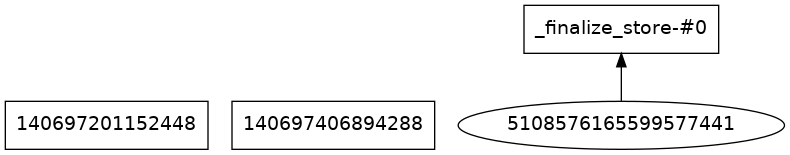

In [53]:
zs.dask.visualize(format='png')

To confirm that the problem is in fact upstream (not in the to_store), we replaced the resulting dask array with an empty array to force the memory to be emptied. This showed the same issues though: High memory usage, store/final compute tasks are not executed.

In [135]:
out2 = out.test.data.map_blocks(lambda x: np.empty((0,0,0)))

In [138]:
# out2.compute()

## Check out the task graph

In [136]:
client.restart()

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.f032bf296137454ca35377d93205b903 Dashboard: /services/dask-gateway/clusters/prod.f032bf296137454ca35377d93205b903/status,Cluster Workers: 9 Cores: 18 Memory: 77.31 GB


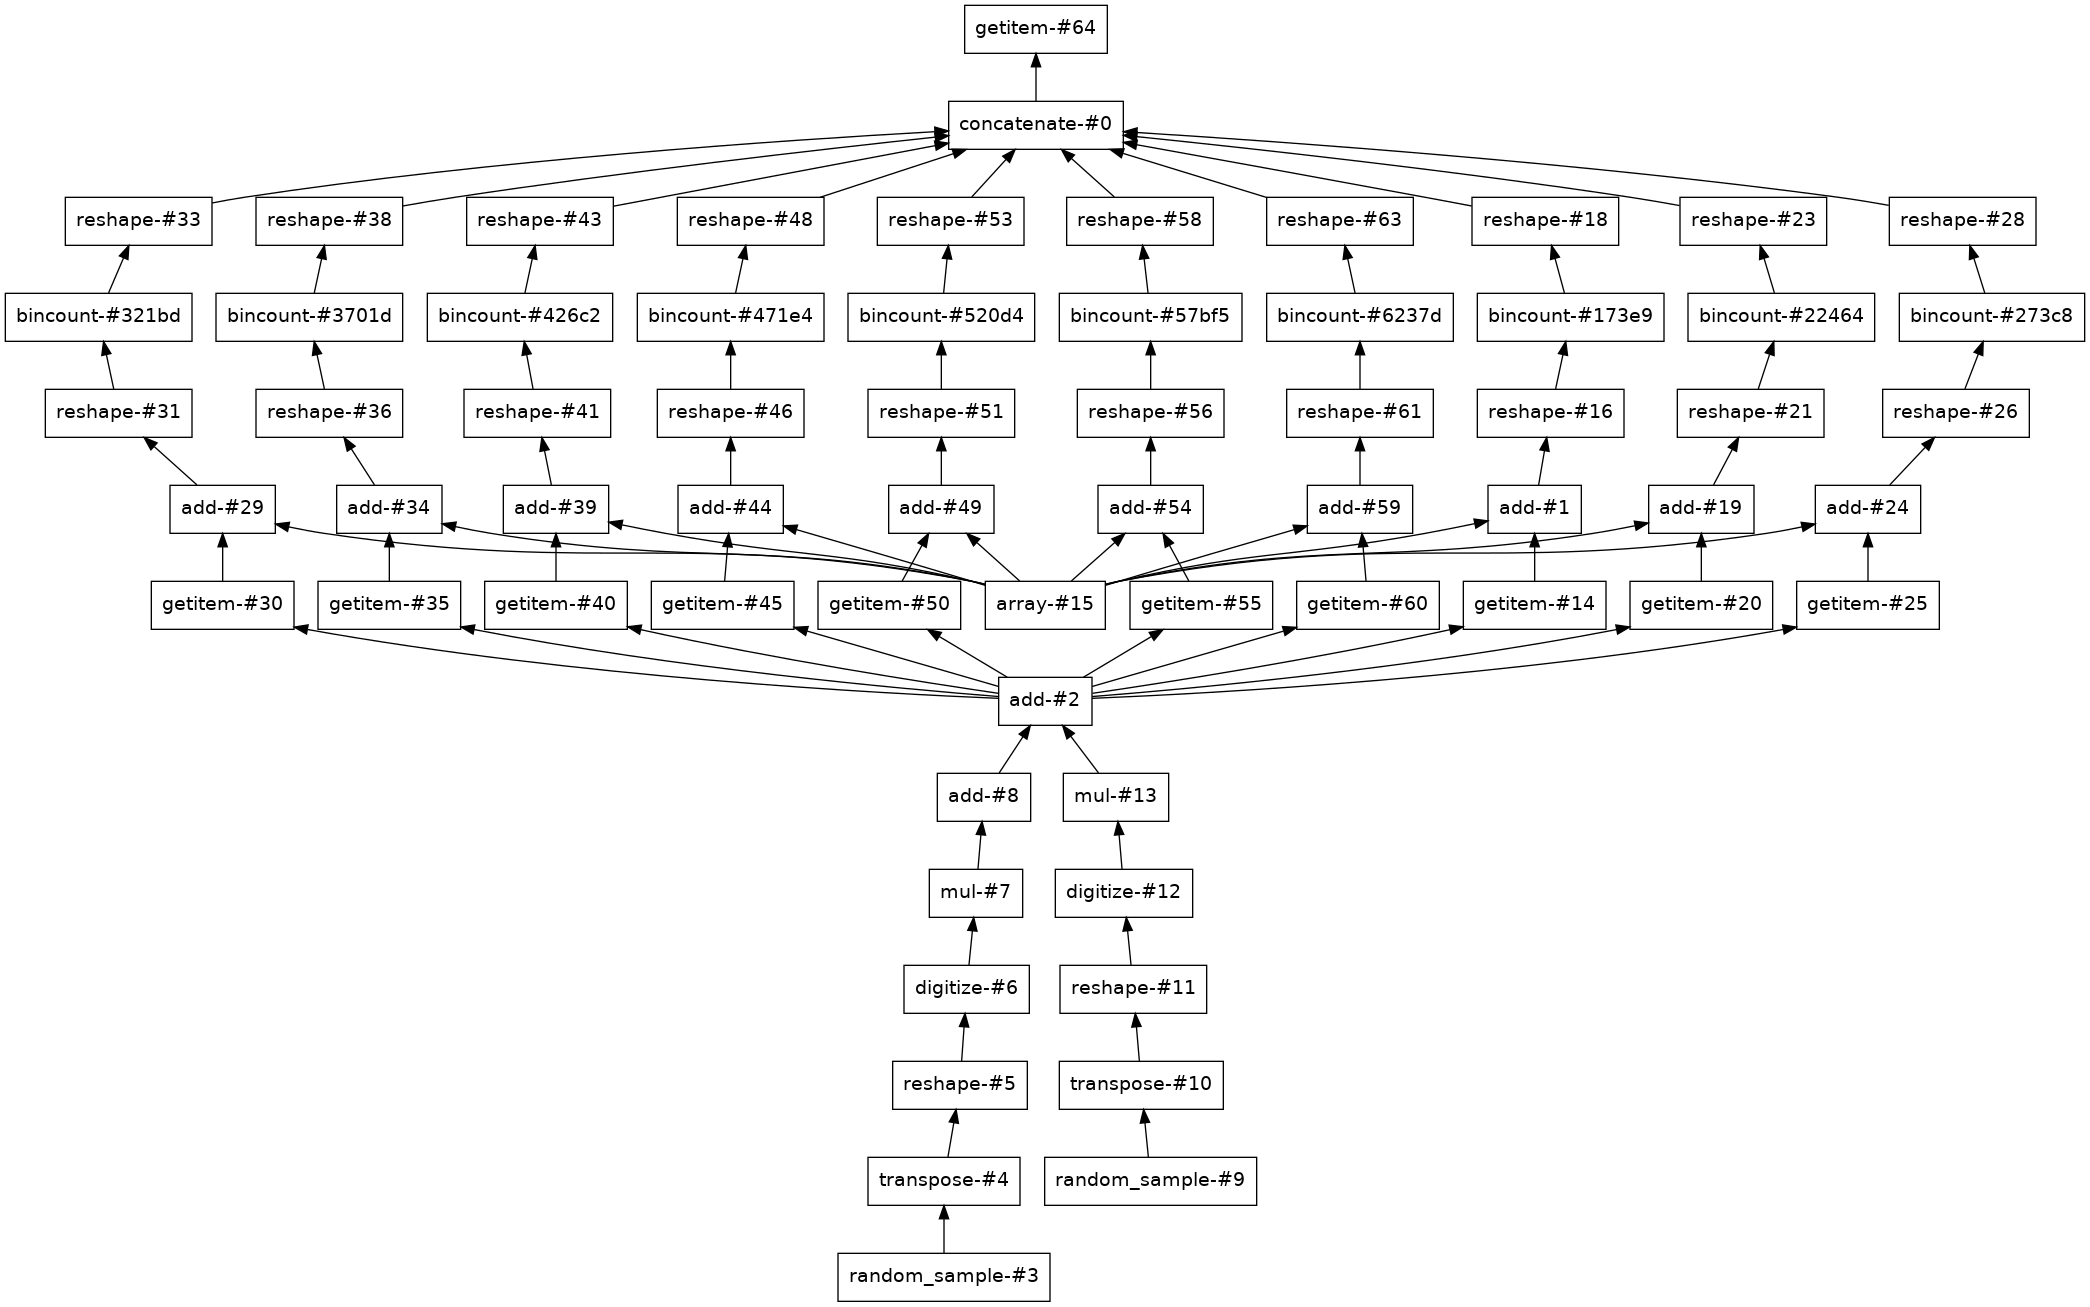

In [137]:
out.test.data.dask.visualize(format='png') #, optimize_graph=True

The 'fanning' 